In [1]:
# %pip install -r /home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/model/CelebV2/requirements.txt

# # Step 1: Uninstall incompatible NumPy version
# %pip uninstall numpy -y
# # Step 2: Install compatible NumPy version (< 2.0.0)
# %pip install "numpy>=1.21.0,<2.0.0"
# # Step 3: Verify NumPy version
# import numpy as np
# print(f"✅ NumPy version: {np.__version__}")
# print(f"Expected: < 2.0.0 (you should see 1.x.x)")

In [2]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

2025-10-18 17:21:49.771483: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 17:21:49.817694: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-18 17:21:50.208761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-18 17:21:50.208818: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-18 17:21:50.210494: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
# Define the path to the dataset
base_path = '/home/huuquangdang/huu.quang.dang/thesis/Dataset/facep/faceplus_processed_research_final_2_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,855_801_frame_0018.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,855,18,fake,0
1,686_696_frame_0024.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,686,24,fake,0
2,664_668_frame_0017.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,664,17,fake,0
3,486_680_frame_0010.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,486,10,fake,0
4,464_463_frame_0005.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,464,5,fake,0
...,...,...,...,...,...,...
59803,140_frame_0025.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,140,25,real,1
59804,937_frame_0007.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,937,7,real,1
59805,092_frame_0001.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,92,1,real,1
59806,736_frame_0018.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,736,18,real,1


In [5]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [6]:
# !pip install opencv-python

In [7]:
# Load pre-extracted CSV features for feature fusion
print("📂 Loading pre-extracted OpenFace features from CSV files...")
csv_fake_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/fake/fpp_fake_v1.csv'
csv_real_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/real/fpp_real_v1.csv'

df_fake_features = pd.read_csv(csv_fake_path, header=None)
df_real_features = pd.read_csv(csv_real_path, header=None)

# Combine both dataframes
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)
df_all_features.columns = ['filename'] + [f'feat_{i}' for i in range(df_all_features.shape[1] - 1)]

# Create a dictionary for fast lookup: filename -> features
openface_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    features = row.iloc[1:].values.astype('float32')
    openface_features[filename] = features

csv_feature_dim = len(features)
print(f"✅ Loaded {len(openface_features)} feature vectors")
print(f"✅ Each vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")

📂 Loading pre-extracted OpenFace features from CSV files...
✅ Loaded 59808 feature vectors
✅ Each vector has 674 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


# 🔬 Alternative Model: BiLSTM + Attention + KAN

This cell implements **BiLSTM with Attention mechanism** instead of standard LSTM, while maintaining:
- ✅ Same function names (`VideoSequence`, `build_model`, `hmm_postprocess`)
- ✅ Same 1-to-1 feature fusion (MobileNet + CSV)
- ✅ Same normalization strategy
- ✅ Enhanced with Bidirectional LSTM and Attention layer

In [8]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, 
    Concatenate, BatchNormalization, Bidirectional, Attention, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from tfkan.layers import Conv2DKAN, DenseKAN
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration (same as before)
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Normalize CSV features (same normalization strategy)
print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in openface_features:
            all_csv_features.append(openface_features[filename])

csv_scaler = StandardScaler()
csv_scaler.fit(all_csv_features)
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")

# Data generator (SAME NAME, same functionality)
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load CSV features and normalize (1-to-1 mapping)
                filename = os.path.basename(path)
                if filename in openface_features:
                    csv_feat = openface_features[filename]
                    csv_feat = csv_scaler.transform([csv_feat])[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)

# BiLSTM + Attention + KAN Model
def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # BatchNormalization before fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)
    
    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])
    
    # 🆕 BiLSTM layers (Bidirectional LSTM)
    x = Bidirectional(LSTM(128, return_sequences=True, name='bilstm_1'))(x_combined)
    x = Dropout(0.3, name='dropout_1')(x)
    x = Bidirectional(LSTM(64, return_sequences=True, name='bilstm_2'))(x)
    x = Dropout(0.3, name='dropout_2')(x)
    
    # 🆕 Attention mechanism using tf.keras.layers.Attention
    attn_output = Attention(name='attention')([x, x])
    # Global average pooling over time dimension to get fixed-size output
    x = tf.keras.layers.GlobalAveragePooling1D(name='global_avg_pool')(attn_output)
    x = Dropout(0.2, name='dropout_attention')(x)
    
    # Classification layers
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(0.2, name='dropout_3')(x)
    x = Dense(32, activation='relu', name='dense_2')(x)
    x = Dropout(0.2, name='dropout_4')(x)
    
    # KAN output layer
    x = DenseKAN(1, name='kan_output')(x)
    output = tf.keras.activations.sigmoid(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='BiLSTM_Attention_KAN')
    return model

# HMM post-processing (SAME NAME, unchanged)
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold
print("\n🚀 Starting BiLSTM + Attention + KAN Training:")
print("   ✅ Bidirectional LSTM (128 + 64 units)")
print("   ✅ Keras Attention mechanism (robust)")
print("   ✅ Normalized CSV features (1-to-1 mapping)")
print("   ✅ MobileNet (last 20 layers trainable)")
print("   ✅ KAN output layer")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - BiLSTM_Attention_KAN")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size, csv_feature_dim)
    model.compile(optimizer=Adamax(3e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    print(f"\n📈 Model Architecture:")
    print(f"   - Model: BiLSTM + Attention + KAN")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - BiLSTM: 128 + 64 units (bidirectional)")
    print(f"   - Attention: Keras Attention layer (robust)")
    print(f"   - Learning rate: 3e-4")

    model_path = f"best_model_fold{fold}_bilstm_attn_kan.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results (BiLSTM_Attention_KAN):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - BiLSTM_Attention_KAN Model")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))

🔧 Computing CSV feature statistics for normalization...
✅ CSV feature normalization fitted on 19982 samples

🚀 Starting BiLSTM + Attention + KAN Training:
   ✅ Bidirectional LSTM (128 + 64 units)
   ✅ Keras Attention mechanism (robust)
   ✅ Normalized CSV features (1-to-1 mapping)
   ✅ MobileNet (last 20 layers trainable)
   ✅ KAN output layer
   ✅ HMM post-processing


📊 Fold 1/5 - BiLSTM_Attention_KAN

📈 Model Architecture:
   - Model: BiLSTM + Attention + KAN
   - Total params: 4,574,153
   - Trainable params: 3,517,957
   - BiLSTM: 128 + 64 units (bidirectional)
   - Attention: Keras Attention layer (robust)
   - Learning rate: 3e-4
Epoch 1/50


2025-10-18 17:22:05.894369: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


45/45 [==============================] - ETA: 0s - loss: 0.6362 - accuracy: 0.7000

2025-10-18 17:24:37.952773: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_accuracy improved from -inf to 0.73125, saving model to best_model_fold1_bilstm_attn_kan.h5
45/45 [==============================] - 163s 3s/step - loss: 0.6362 - accuracy: 0.7000 - val_loss: 0.6097 - val_accuracy: 0.7312 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.8236
Epoch 2: val_accuracy did not improve from 0.73125
45/45 [==============================] - 148s 3s/step - loss: 0.4677 - accuracy: 0.8236 - val_loss: 0.5917 - val_accuracy: 0.6812 - lr: 3.0000e-04
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.3120 - accuracy: 0.8889
Epoch 3: val_accuracy did not improve from 0.73125
45/45 [==============================] - 148s 3s/step - loss: 0.3120 - accuracy: 0.8889 - val_loss: 0.6598 - val_accuracy: 0.7250 - lr: 3.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9375
Epoch 4: val_accuracy improved from 0.73125 to 0.85625, saving model to best_model_fold1_bilstm_attn_kan.h5
45/45 [==============================] - 147s 3s/step - loss: 0.2075 - accuracy: 0.9375 - val_loss: 0.3649 - val_accuracy: 0.8562 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9556
Epoch 5: val_accuracy did not improve from 0.85625
45/45 [==============================] - 146s 3s/step - loss: 0.1325 - accuracy: 0.9556 - val_loss: 0.4382 - val_accuracy: 0.8375 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9819
Epoch 6: val_accuracy did not improve from 0.85625
45/45 [==============================] - 146s 3s/step - loss: 0.0828 - accuracy: 0.9819 - val_loss: 0.6366 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9910
Epoch 7: val_accuracy improved from 0.85625 to 0.86250, saving model to best_model_fold1_bilstm_attn_kan.h5

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 145s 3s/step - loss: 0.0490 - accuracy: 0.9910 - val_loss: 0.5073 - val_accuracy: 0.8625 - lr: 3.0000e-04
E

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9951
Epoch 8: val_accuracy did not improve from 0.86250
45/45 [==============================] - 146s 3s/step - loss: 0.0297 - accuracy: 0.9951 - val_loss: 0.5711 - val_accuracy: 0.8625 - lr: 1.5000e-04
Epoch 9/50
45/45 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9944
Epoch 9: val_accuracy did not improve from 0.86250
45/45 [==============================] - 144s 3s/step - loss: 0.0275 - accuracy: 0.9944 - val_loss: 0.6484 - val_accuracy: 0.8375 - lr: 1.5000e-04
Epoch 10/50
45/45 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9972
Epoch 10: val_accuracy did not improve from 0.86250

Epoch 10: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
45/45 [==============================] - 145s 3s/step - loss: 0.0216 - accuracy: 0.9972 - val_loss: 0.6459 - val_accuracy: 0.8375 - lr: 1.5000e-04
Epoch 11/50
45/45 [==============================] - ET

2025-10-18 17:51:30.822507: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


13/13 [==============================] - 17s 1s/step

✅ Fold 1 Results (BiLSTM_Attention_KAN):
   Accuracy:  0.8375
   Precision: 0.8054
   Recall:    0.8900
   F1 Score:  0.8456
   AUC:       0.9206

📊 Fold 2/5 - BiLSTM_Attention_KAN

📈 Model Architecture:
   - Model: BiLSTM + Attention + KAN
   - Total params: 4,574,153
   - Trainable params: 3,517,957
   - BiLSTM: 128 + 64 units (bidirectional)
   - Attention: Keras Attention layer (robust)
   - Learning rate: 3e-4
Epoch 1/50


2025-10-18 17:51:53.460046: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


45/45 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.7028

2025-10-18 17:54:12.785810: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_accuracy improved from -inf to 0.71250, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 150s 3s/step - loss: 0.6162 - accuracy: 0.7028 - val_loss: 0.6031 - val_accuracy: 0.7125 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8368
Epoch 2: val_accuracy improved from 0.71250 to 0.78125, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 146s 3s/step - loss: 0.4132 - accuracy: 0.8368 - val_loss: 0.4666 - val_accuracy: 0.7812 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.8979
Epoch 3: val_accuracy improved from 0.78125 to 0.78750, saving model to best_model_fold2_bilstm_attn_kan.h5
45/45 [==============================] - 145s 3s/step - loss: 0.2580 - accuracy: 0.8979 - val_loss: 0.4213 - val_accuracy: 0.7875 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9438
Epoch 4: val_accuracy did not improve from 0.78750
45/45 [==============================] - 145s 3s/step - loss: 0.1747 - accuracy: 0.9438 - val_loss: 0.5346 - val_accuracy: 0.7437 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.1076 - accuracy: 0.9694
Epoch 5: val_accuracy did not improve from 0.78750
45/45 [==============================] - 144s 3s/step - loss: 0.1076 - accuracy: 0.9694 - val_loss: 0.6461 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9833
Epoch 6: val_accuracy did not improve from 0.78750

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 145s 3s/step - loss: 0.0706 - accuracy: 0.9833 - val_loss: 0.8522 - val_accuracy: 0.7188 - lr: 3.0000e-04
Epoch 7/50
45/45 [==============================] - ETA: 0

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9931
Epoch 8: val_accuracy did not improve from 0.80625
45/45 [==============================] - 145s 3s/step - loss: 0.0357 - accuracy: 0.9931 - val_loss: 0.8279 - val_accuracy: 0.7625 - lr: 1.5000e-04
Epoch 9/50
45/45 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9937
Epoch 9: val_accuracy improved from 0.80625 to 0.84375, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 9: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
45/45 [==============================] - 145s 3s/step - loss: 0.0325 - accuracy: 0.9937 - val_loss: 0.5779 - val_accuracy: 0.8438 - lr: 1.5000e-04
Epoch 10/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9972
Epoch 10: val_accuracy did not improve from 0.84375
45/45 [==============================] - 146s 3s/step - loss: 0.0271 - accuracy: 0.9972 - val_loss: 0.5917 - val_accuracy: 0.8375 - lr: 7.5000e-05
Epoch 11/50
45/45 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9979
Epoch 11: val_accuracy did not improve from 0.84375
45/45 [==============================] - 147s 3s/step - loss: 0.0196 - accuracy: 0.9979 - val_loss: 0.5871 - val_accuracy: 0.8375 - lr: 7.5000e-05
Epoch 12/50
45/45 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9979
Epoch 12: val_accuracy did not improve from 0.84375

Epoch 12: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
45/45 [==============================] - 145s 3s/step - loss: 0.0197 - accuracy: 0.9979 - val_loss: 0.6020 - val_accuracy: 0.8438 - lr: 7.5000e-05
Epoch 13/50
45/45 [==============================] 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9972
Epoch 14: val_accuracy did not improve from 0.85000
45/45 [==============================] - 146s 3s/step - loss: 0.0156 - accuracy: 0.9972 - val_loss: 0.6265 - val_accuracy: 0.8500 - lr: 3.7500e-05
Epoch 15/50
45/45 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9979
Epoch 15: val_accuracy improved from 0.85000 to 0.85625, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
45/45 [==============================] - 146s 3s/step - loss: 0.0150 - accuracy: 0.9979 - val_loss: 0.6447 - val_accuracy: 0.8562 - lr: 3.7500e-05
Epoch 16/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9972
Epoch 16: val_accuracy did not improve from 0.85625
45/45 [==============================] - 146s 3s/step - loss: 0.0153 - accuracy: 0.9972 - val_loss: 0.6641 - val_accuracy: 0.8562 - lr: 1.8750e-05
Epoch 17/50
45/45 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9979
Epoch 17: val_accuracy did not improve from 0.85625
45/45 [==============================] - 145s 3s/step - loss: 0.0154 - accuracy: 0.9979 - val_loss: 0.6729 - val_accuracy: 0.8562 - lr: 1.8750e-05
Epoch 18/50
45/45 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9979
Epoch 18: val_accuracy did not improve from 0.85625

Epoch 18: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
45/45 [==============================] - 145s 3s/step - loss: 0.0124 - accuracy: 0.9979 - val_loss: 0.6880 - val_accuracy: 0.8438 - lr: 1.8750e-05
Epoch 19/50
45/45 [==============================] -

2025-10-18 18:40:20.232450: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


13/13 [==============================] - 17s 1s/step

✅ Fold 2 Results (BiLSTM_Attention_KAN):
   Accuracy:  0.8450
   Precision: 0.8594
   Recall:    0.8250
   F1 Score:  0.8418
   AUC:       0.9197

📊 Fold 3/5 - BiLSTM_Attention_KAN

📈 Model Architecture:
   - Model: BiLSTM + Attention + KAN
   - Total params: 4,574,153
   - Trainable params: 3,517,957
   - BiLSTM: 128 + 64 units (bidirectional)
   - Attention: Keras Attention layer (robust)
   - Learning rate: 3e-4
Epoch 1/50


2025-10-18 18:40:42.438741: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


45/45 [==============================] - ETA: 0s - loss: 0.6443 - accuracy: 0.6486

2025-10-18 18:43:02.053433: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to best_model_fold3_bilstm_attn_kan.h5
45/45 [==============================] - 150s 3s/step - loss: 0.6443 - accuracy: 0.6486 - val_loss: 0.6334 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.4730 - accuracy: 0.8125
Epoch 2: val_accuracy improved from 0.75000 to 0.78750, saving model to best_model_fold3_bilstm_attn_kan.h5
45/45 [==============================] - 145s 3s/step - loss: 0.4730 - accuracy: 0.8125 - val_loss: 0.5030 - val_accuracy: 0.7875 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8813
Epoch 3: val_accuracy improved from 0.78750 to 0.81250, saving model to best_model_fold3_bilstm_attn_kan.h5
45/45 [==============================] - 147s 3s/step - loss: 0.3226 - accuracy: 0.8813 - val_loss: 0.4180 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9271
Epoch 4: val_accuracy improved from 0.81250 to 0.83125, saving model to best_model_fold3_bilstm_attn_kan.h5
45/45 [==============================] - 145s 3s/step - loss: 0.2227 - accuracy: 0.9271 - val_loss: 0.3949 - val_accuracy: 0.8313 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9583
Epoch 5: val_accuracy did not improve from 0.83125
45/45 [==============================] - 145s 3s/step - loss: 0.1461 - accuracy: 0.9583 - val_loss: 0.4290 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9729
Epoch 6: val_accuracy did not improve from 0.83125
45/45 [==============================] - 145s 3s/step - loss: 0.1000 - accuracy: 0.9729 - val_loss: 0.5474 - val_accuracy: 0.8188 - lr: 3.0000e-04
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9792
Epoch 7: val_accuracy did not improve from 0.83125

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 145s 3s/step - loss: 0.0744 - accuracy: 0.9792 - val_loss: 0.6722 - val_accuracy: 0.7875 - lr: 3.0000e-04
Epoch 8/50
45/45 [==============================] - ETA: 0

2025-10-18 19:02:32.214152: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


13/13 [==============================] - 17s 1s/step

✅ Fold 3 Results (BiLSTM_Attention_KAN):
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1 Score:  1.0000
   AUC:       0.9442

📊 Fold 4/5 - BiLSTM_Attention_KAN

📈 Model Architecture:
   - Model: BiLSTM + Attention + KAN
   - Total params: 4,574,153
   - Trainable params: 3,517,957
   - BiLSTM: 128 + 64 units (bidirectional)
   - Attention: Keras Attention layer (robust)
   - Learning rate: 3e-4
Epoch 1/50


2025-10-18 19:02:54.160855: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


45/45 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.5986

2025-10-18 19:05:13.801470: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_accuracy improved from -inf to 0.66875, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 150s 3s/step - loss: 0.6632 - accuracy: 0.5986 - val_loss: 0.6616 - val_accuracy: 0.6687 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.8049
Epoch 2: val_accuracy improved from 0.66875 to 0.77500, saving model to best_model_fold4_bilstm_attn_kan.h5
45/45 [==============================] - 145s 3s/step - loss: 0.5066 - accuracy: 0.8049 - val_loss: 0.5272 - val_accuracy: 0.7750 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.8806
Epoch 3: val_accuracy did not improve from 0.77500
45/45 [==============================] - 145s 3s/step - loss: 0.3388 - accuracy: 0.8806 - val_loss: 0.5798 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.2237 - accuracy: 0.9292
Epoch 4: val_accuracy did not improve from 0.77500
45/45 [==============================] - 145s 3s/step - loss: 0.2237 - accuracy: 0.9292 - val_loss: 0.6284 - val_accuracy: 0.7000 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9549
Epoch 5: val_accuracy did not improve from 0.77500

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
45/45 [==============================] - 145s 3s/step - loss: 0.1525 - accuracy: 0.9549 - val_loss: 0.5351 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0

2025-10-18 19:19:51.075262: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


13/13 [==============================] - 17s 1s/step

✅ Fold 4 Results (BiLSTM_Attention_KAN):
   Accuracy:  0.5000
   Precision: 0.0000
   Recall:    0.0000
   F1 Score:  0.0000
   AUC:       0.8798

📊 Fold 5/5 - BiLSTM_Attention_KAN


/home/huuquangdang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



📈 Model Architecture:
   - Model: BiLSTM + Attention + KAN
   - Total params: 4,574,153
   - Trainable params: 3,517,957
   - BiLSTM: 128 + 64 units (bidirectional)
   - Attention: Keras Attention layer (robust)
   - Learning rate: 3e-4
Epoch 1/50


2025-10-18 19:20:13.059717: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


45/45 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.6194

2025-10-18 19:22:34.987389: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_accuracy improved from -inf to 0.55625, saving model to best_model_fold5_bilstm_attn_kan.h5
45/45 [==============================] - 152s 3s/step - loss: 0.6445 - accuracy: 0.6194 - val_loss: 0.6456 - val_accuracy: 0.5562 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.4779 - accuracy: 0.8139
Epoch 2: val_accuracy improved from 0.55625 to 0.81250, saving model to best_model_fold5_bilstm_attn_kan.h5
45/45 [==============================] - 147s 3s/step - loss: 0.4779 - accuracy: 0.8139 - val_loss: 0.5127 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.8833
Epoch 3: val_accuracy did not improve from 0.81250
45/45 [==============================] - 147s 3s/step - loss: 0.3064 - accuracy: 0.8833 - val_loss: 0.4264 - val_accuracy: 0.7750 - lr: 3.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9354
Epoch 4: val_accuracy did not improve from 0.81250
45/45 [==============================] - 147s 3s/step - loss: 0.1987 - accuracy: 0.9354 - val_loss: 0.6666 - val_accuracy: 0.6562 - lr: 3.0000e-04
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9667
Epoch 5: val_accuracy did not improve from 0.81250
45/45 [==============================] - 147s 3s/step - loss: 0.1205 - accuracy: 0.9667 - val_loss: 0.4917 - val_accuracy: 0.7312 - lr: 3.0000e-04
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9736
Epoch 6: val_accuracy did not improve fro

2025-10-18 19:37:24.961620: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "106" frequency: 2611 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 18874368 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


13/13 [==============================] - 17s 1s/step

✅ Fold 5 Results (BiLSTM_Attention_KAN):
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1 Score:  1.0000
   AUC:       0.8851

📊 FINAL RESULTS - BiLSTM_Attention_KAN Model
Fold 1: Acc=0.8375, Prec=0.8054, Rec=0.8900, F1=0.8456, AUC=0.9206
Fold 2: Acc=0.8450, Prec=0.8594, Rec=0.8250, F1=0.8418, AUC=0.9197
Fold 3: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000, AUC=0.9442
Fold 4: Acc=0.5000, Prec=0.0000, Rec=0.0000, F1=0.0000, AUC=0.8798
Fold 5: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000, AUC=0.8851

📊 Average Metrics:
fold         3.000000
accuracy     0.836500
precision    0.732961
recall       0.743000
f1           0.737488
auc          0.909880
dtype: float64


In [9]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.836500
precision    0.732961
recall       0.743000
f1           0.737488
auc          0.909880
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.8375,0.805430,0.890,0.845606,0.920600
1,2,0.8450,0.859375,0.825,0.841837,0.919725
2,3,1.0000,1.000000,1.000,1.000000,0.944200
3,4,0.5000,0.000000,0.000,0.000000,0.879750
4,5,1.0000,1.000000,1.000,1.000000,0.885125


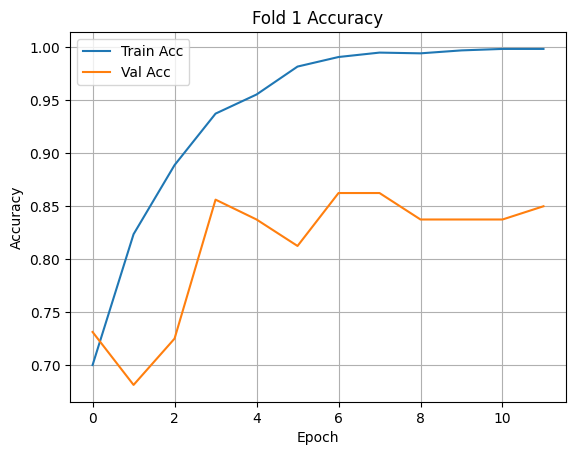

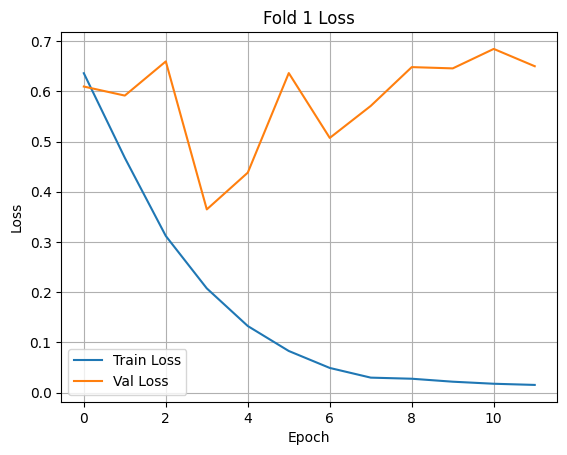

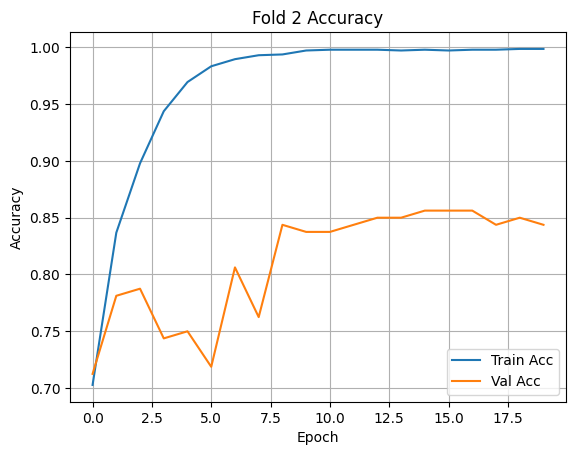

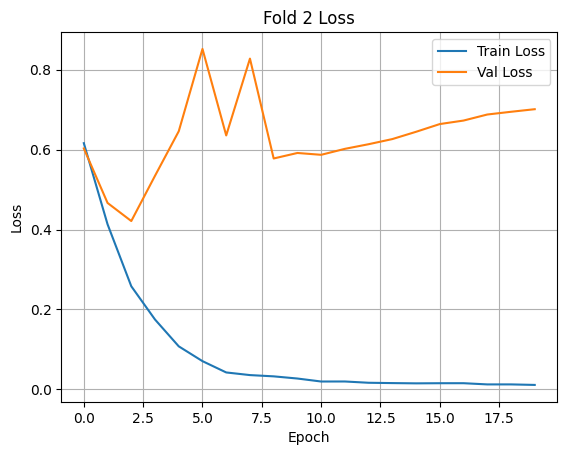

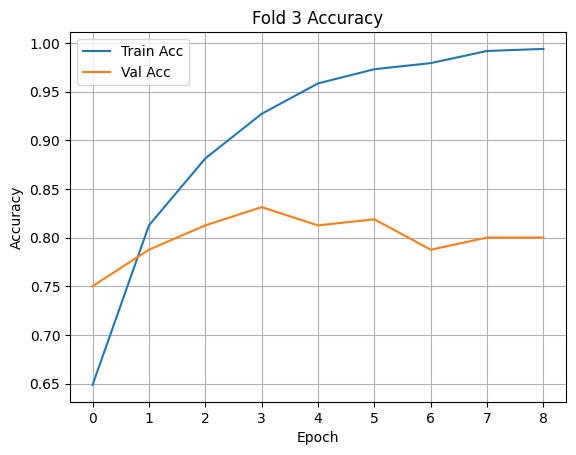

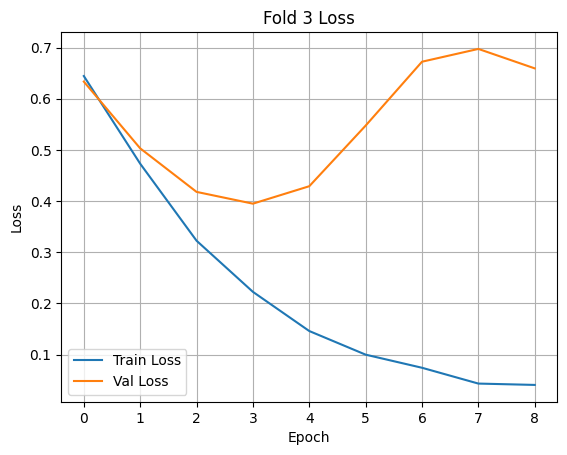

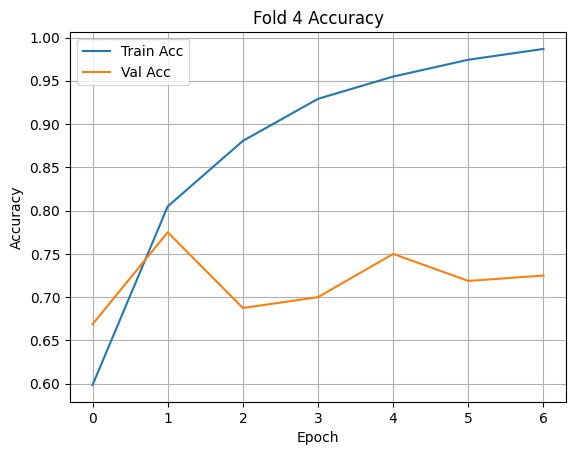

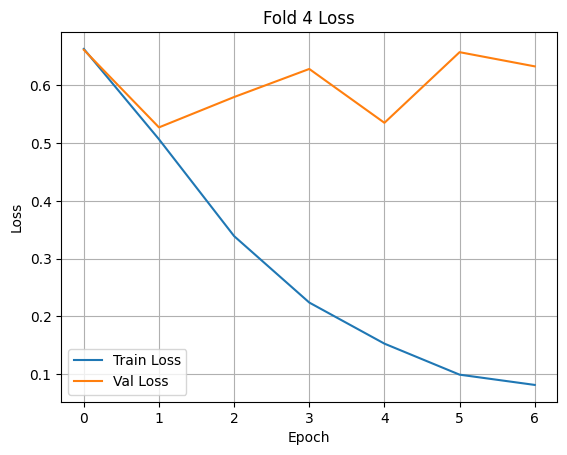

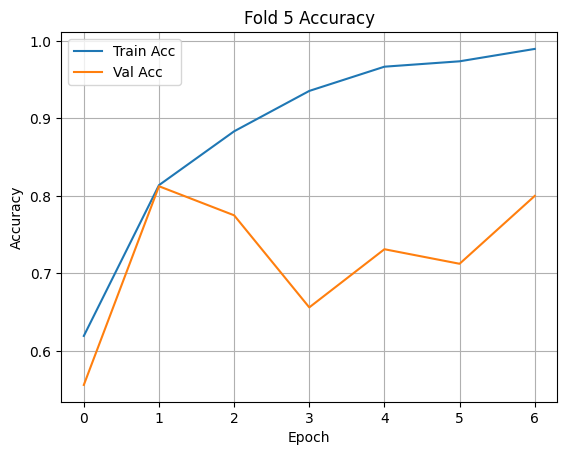

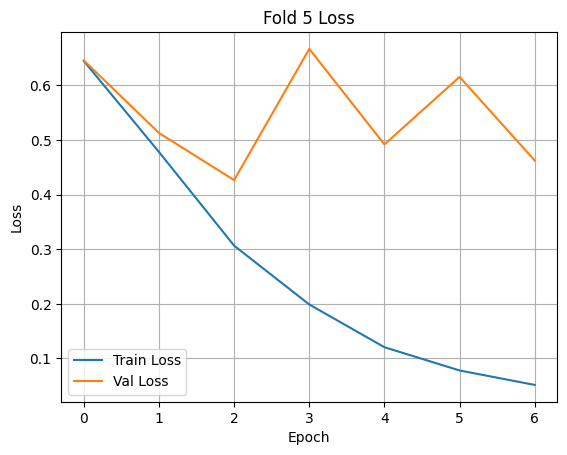

In [10]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_hmm_faceplus_final.h5")


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.836500
precision    0.732961
recall       0.743000
f1           0.737488
auc          0.909880
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.8375,0.805430,0.890,0.845606,0.920600
1,2,0.8450,0.859375,0.825,0.841837,0.919725
2,3,1.0000,1.000000,1.000,1.000000,0.944200
3,4,0.5000,0.000000,0.000,0.000000,0.879750
4,5,1.0000,1.000000,1.000,1.000000,0.885125


In [13]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.836500
precision    0.732961
recall       0.743000
f1           0.737488
auc          0.909880
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.8365
📈 Range Accuracy: 0.5000
📉 Accuracy CV% (std/mean): 24.41%


,fold,accuracy,precision,recall,f1,auc
0,1,0.8375,0.805430,0.890,0.845606,0.920600
1,2,0.8450,0.859375,0.825,0.841837,0.919725
2,3,1.0000,1.000000,1.000,1.000000,0.944200
3,4,0.5000,0.000000,0.000,0.000000,0.879750
4,5,1.0000,1.000000,1.000,1.000000,0.885125


# BiLSTM + Attention + KAN Model (BiLSTM_Attn_KAN)
This notebook now uses only the BiLSTM_Attn_KAN architecture for deepfake detection. All model definition, training, and results cells are updated to reflect this.